# Detuning Map

In this notebook, we developed a `detuning map channel` to apply detuning to each qubit in the NAQC, proportional to its population coverage. After optimizing this process, we observed that, for our type of graph, this **provided no advantage**. This notebook outlines the implementation of the detuning map. However, as no benefit was observed, we retained the pulse profile from `pulse_optimization` and chose not to apply the Detuning Map in `main_algorithm` for simplicity.

## Import required libraries

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as scipy
from scipy.spatial import KDTree, distance
from scipy.spatial.distance import pdist
import json
# graph representation
import networkx as nx
# Pulser imports
from pulser import Pulse, Sequence, Register
import pulser as pulser
from pulser.devices import MockDevice
from pulser.waveforms import RampWaveform, ConstantWaveform
from pulser_simulation import SimConfig, QutipEmulator
from pulser.channels.dmm import DMM

## Define Problem Data

### Retrieve popuplation

In [48]:
cities = ["Bradleymouth", "Brandonberg", "Hansenchester", "Joshuachester", "New Rebeccaberg", "North Carl", "North Christopherbury", "Port Jonathan", "Zacharyburgh", 'North Joshua']
city_name = cities[0]

with open('./data/population_{}.json'.format(city_name), 'r') as json_file:
    data = json.load(json_file)

params = data['info']
x = np.array(data['x'])
y = np.array(data['y'])

### Coverage function to maximize

In [49]:
def evaluate_coverage(data, placement, R_dist):
    x = np.array(data['x'])
    y = np.array(data['y'])
    B = len(x)
    coords = np.array([[x[i], y[i]] for i in range(len(x))])
    cost = 0
    for i in range(len(placement)):
        coord_i = np.array([placement[i]])
        for j in range(len(placement)):
            coord_j = np.array([placement[j]])
            if i != j:
                dist = scipy.spatial.distance.cdist(coord_i, coord_j)
                if dist < (2 + 1e-3)*R_dist:
                    cost += -B


        dist = scipy.spatial.distance.cdist(coord_i, coords)
        cov = np.sum(dist < R_dist)
        cost += cov

    if cost < 0:
        return -np.inf
    else:
        return cost
    
# function to compute coverage of an array of grid_points
def simple_coverage(population_x, population_y, grid_points, R_antennas):
    z_coverage = np.zeros(len(grid_points))
    coords = np.array([[population_x[i], population_y[i]] for i in range(len(population_x))])
    for i in range(len(grid_points)):
        start = np.array(grid_points[i])
        dist = scipy.spatial.distance.cdist(np.array([start]), coords)
        truth_table = (dist <= R_antennas)
        cov = np.sum(truth_table)
        z_coverage[i] = cov
    return z_coverage

### Functions to generate the grid

In [50]:

def generate_triangular_grid(side_lengths, spacing, offset):
    """
    Generates a grid of points in a triangular (hexagonal) lattice pattern.

    Parameters:
    - side_lengths: Tuple (rows, cols) representing the number of rows and columns in the grid.
    - spacing: Distance between adjacent points in the grid.
    - offset: Tuple (x_offset, y_offset) that shifts the entire grid by these values.

    Returns:
    - points: List of [x, y] coordinates for each point in the triangular grid.
    """
    rows, cols = side_lengths
    points = []  # Initialize an empty list to store grid points
    for row in range(rows): # Loop through each row
        for col in range(cols): # Loop through each column in the row
            # Calculate the x coordinate
            x = col * spacing
            # Offset every other row by half the side length
            if row % 2 == 1:
                x += spacing / 2
            # Calculate the y coordinate based on the row number
            y = row * (spacing * (3**0.5) / 2)  # Height of an equilateral triangle
            points.append([x + offset[0], y + offset[1]])
    return points 

# Function to adaptively select points from a triangular grid with minimum interference
def adaptive_selection_with_min_dist(grid_points, max_grid_points,interference_threshold):
    """
    Selects up to a specified number of points from a grid while ensuring a minimum distance between selected points.

    Parameters:
    - grid_points: List of [x, y] coordinates in the initial grid.
    - max_grid_points: Maximum number of points to select.
    - interference_threshold: Minimum allowable distance between any two selected points.

    Returns:
    - selected_points: List of selected [x, y] coordinates that meet the interference threshold criteria.
    """
    selected_points = []
    while len(selected_points) < max_grid_points and grid_points:
        # Choose the point with the best coverage from remaining points
        point = grid_points.pop(0)
        # Calculate interference with selected points
        if selected_points:
            dists_to_selected = distance.cdist([point], selected_points, 'euclidean')
            min_dist_to_selected = np.min(dists_to_selected)

            # Skip this point if it interferes too much with any selected point
            if min_dist_to_selected < interference_threshold:
                continue
        # Select this point
        selected_points.append(point) 
    return selected_points

Generate the grid and calculate the population coverage for each grid points. We will use those population coverage later as weights for each qubit in the NAQC register.

In [51]:
# Define parameters
population_x = x
population_y = y
offset = [population_x.min(), population_y.min()]  # Offset to start grid at (0, 0)
R_antennas = 25  # Operating radius for each antenna
spacing = R_antennas/3  # Use a small spacing for high precision
side_lengths = (
        int(np.ceil((population_x.max() - population_x.min()) / spacing)),
        int(np.ceil((population_y.max() - population_y.min()) / spacing))
    )

max_grid_points = 10 # Maximum number of antennas
interference_threshold = 1.5*R_antennas  #minimum distance between gridpoints
grid_points = adaptive_selection_with_min_dist(generate_triangular_grid(side_lengths, spacing, offset), max_grid_points, interference_threshold)

# Calculate final coverage for the selected grid layout
z_coverage = simple_coverage(population_x, population_y, grid_points, R_antennas)

In [52]:
device_used = pulser.devices.MockDevice
# create an UD graph embedding using appropriate coordinates
coords = np.array(grid_points)
val = np.min(pdist(coords))
factor = 5/val
coords = coords*factor # Normalize to 5 b.c. minimum distance on real NAQC is around 4um

# set Rabi frequency and detuning 
# Parameters in rad/µs and ns
omega_max = 2 * np.pi   # the maximum Rabi frequency, stays constant throughout the code
delta_0 = -6 * omega_max
delta_f = 2 * omega_max
t_rise = 252
t_fall = 500
t_sweep = (delta_f - delta_0) / (2 * np.pi * 10) * 2000

# scaling of the graph to map it inside the register
rydberg_radius = device_used.rydberg_blockade_radius(omega_max)
R_antennas = 25*factor
factor_for_rydberg_scaling = rydberg_radius/(2*R_antennas)
R_antennas = R_antennas * factor_for_rydberg_scaling
coords = coords * factor_for_rydberg_scaling

# Noise configuration
noise_config = {
    "noiseless": None,
    "noisy": SimConfig(
        noise = ("SPAM", "dephasing", "doppler"),
        eta = 0.8,
        temperature = 1000,
        runs = 50,
    )
}
print('Omega_max:', omega_max)
print('Rydberg radius:', rydberg_radius)
print('Delta_0:', delta_0)
print('Delta_f:', delta_f)
print('t_rise:', t_rise)
print('t_fall:', t_fall)
print('t_sweep:', t_sweep)

Omega_max: 6.283185307179586
Rydberg radius: 9.756753962298905
Delta_0: -37.69911184307752
Delta_f: 12.566370614359172
t_rise: 252
t_fall: 500
t_sweep: 1600.0


### Create the register

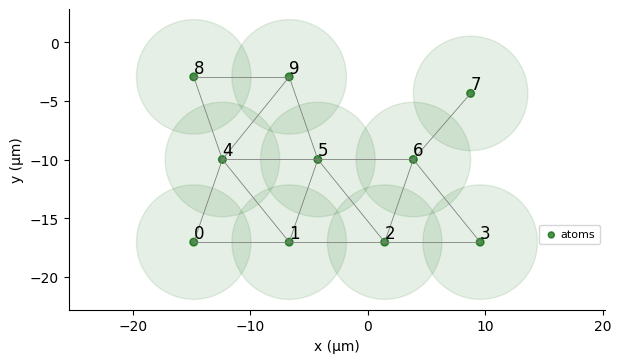

In [53]:
# create a register on NAQC
qubits = dict(enumerate(coords))
reg = Register(qubits)
reg.draw(
    blockade_radius=device_used.rydberg_blockade_radius(omega_max),
    draw_graph=True,
    draw_half_radius=True,
)

{0: Text(-14.826376546173297, -17.022364529129952, '0'),
 1: Text(-6.695748244257539, -17.022364529129952, '1'),
 2: Text(1.434880057658216, -17.022364529129952, '2'),
 4: Text(-12.387188055598568, -9.981033870942174, '4'),
 5: Text(-4.256559753682814, -9.981033870942174, '5'),
 9: Text(-6.695748244257539, -2.9397032127543974, '9'),
 3: Text(9.565508359573972, -17.022364529129952, '3'),
 6: Text(3.874068548232942, -9.981033870942174, '6'),
 7: Text(8.752445529382396, -4.347969344391953, '7'),
 8: Text(-14.826376546173297, -2.9397032127543974, '8')}

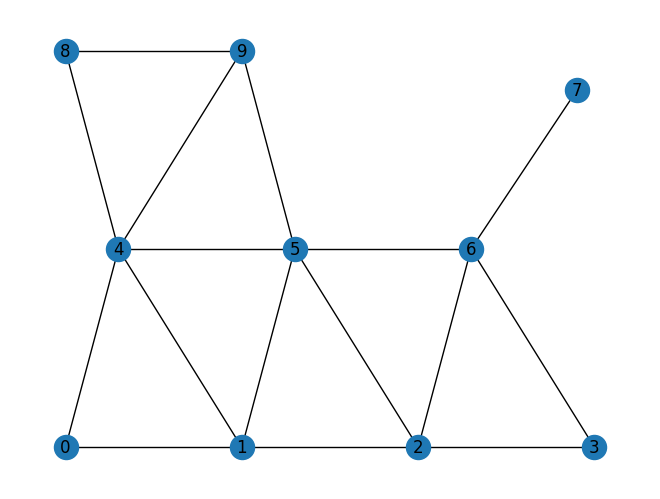

In [54]:
graph = nx.Graph()
edges = KDTree(coords).query_pairs(R_antennas * (2 + 1e-3))
graph.add_edges_from(edges)
nx.draw(graph, pos=coords)
nx.draw_networkx_labels(graph, pos=coords)

# Pulser Implementation

We will now implement a **detuning** on each qubit based on their coverage calculated earlier. 

A qubit having a **high coverage**, and thus a high weight should have a **detuning of zero**. And similarly, a qubit having **zero coverage**, corresponding to a weight of 0, should have a **detuning weight of 1**.

*This will allow us to favorize the excitation of qubits having higher coverage.*

### 1. Calculating the detuning weights as **1 - coverage**

In [55]:
trap_coordinates = np.array(grid_points)
weights = 1 - np.array(z_coverage/np.max(z_coverage))

# Print the weights for each antenna
for i, weight in enumerate(weights):
    print(f"Antenna {i+1}: Coverage = {z_coverage[i]}, Weight = {weight:.2f}")

Antenna 1: Coverage = 4.0, Weight = 0.99
Antenna 2: Coverage = 1.0, Weight = 1.00
Antenna 3: Coverage = 75.0, Weight = 0.76
Antenna 4: Coverage = 1.0, Weight = 1.00
Antenna 5: Coverage = 49.0, Weight = 0.85
Antenna 6: Coverage = 182.0, Weight = 0.43
Antenna 7: Coverage = 319.0, Weight = 0.00
Antenna 8: Coverage = 58.0, Weight = 0.82
Antenna 9: Coverage = 43.0, Weight = 0.87
Antenna 10: Coverage = 141.0, Weight = 0.56


### 2. Calculating the detuning weights based on a log scale
This allow to have a better repartition between the detuning weights

In [56]:
# Apply a logarithmic scaling to normalize the coverage values
# Adding 1 to avoid log(0) in case of 0 coverage
log_scaled_coverage = np.log(np.array(z_coverage) + 1)

# Normalize the log-scaled values between 0 and 1
max_log_coverage = max(log_scaled_coverage)
min_log_coverage = min(log_scaled_coverage)

# Calculate weights: 1 for the lowest coverage and closer to 0 for the highest
if max_log_coverage != min_log_coverage:
    weights = [(max_log_coverage - log_cov) / (max_log_coverage - min_log_coverage) for log_cov in log_scaled_coverage]
else:
    # All antennas have the same coverage; assign a weight of 1
    weights = [1] * len(log_scaled_coverage)

# Print the weights for each antenna
for i, weight in enumerate(weights):
    print(f"Antenna {i+1}: Coverage = {z_coverage[i]}, Weight = {weight:.2f}")

Antenna 1: Coverage = 4.0, Weight = 0.82
Antenna 2: Coverage = 1.0, Weight = 1.00
Antenna 3: Coverage = 75.0, Weight = 0.28
Antenna 4: Coverage = 1.0, Weight = 1.00
Antenna 5: Coverage = 49.0, Weight = 0.37
Antenna 6: Coverage = 182.0, Weight = 0.11
Antenna 7: Coverage = 319.0, Weight = 0.00
Antenna 8: Coverage = 58.0, Weight = 0.33
Antenna 9: Coverage = 43.0, Weight = 0.39
Antenna 10: Coverage = 141.0, Weight = 0.16


We then create the **Detuning Map**

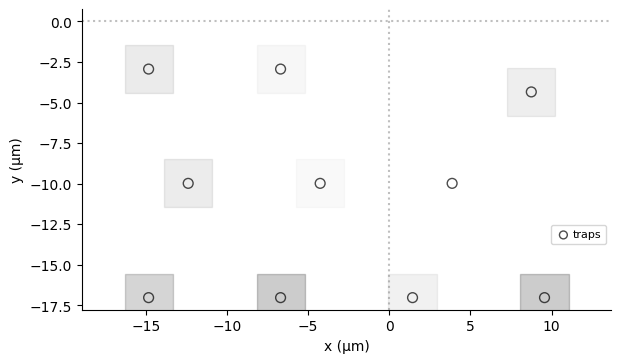

In [57]:
register = Register.from_coordinates(
    coords, center=False, prefix="q"
)
det_map_from_reg = register.define_detuning_map(
    {
        f"q{i}": weights[i] for i in range(len(weights))
    }  # mapping between qubit ids and weights
)

det_map_from_reg.draw()

### Detuning Waveform
We Generate a constant detuning waveform given by the maximum detuning value of the rydberg channel divided by 5:  

**detuning map amplitude = $\Delta_{max}/5$**

{'dmm_0': DMM.Global(Max Absolute Detuning: None, Max Amplitude: 0, Clock period: 1 ns, Minimum pulse duration: 1 ns, Maximum pulse duration: 100000000 ns, Basis: 'ground-rydberg')}


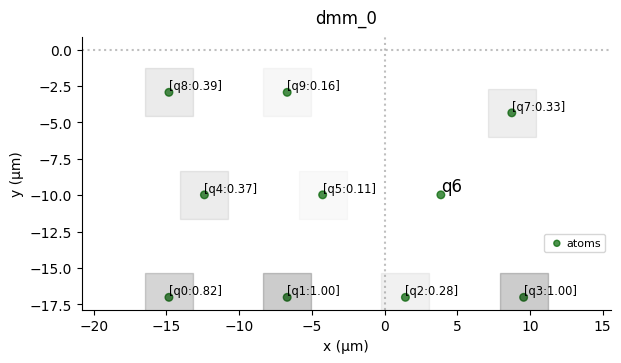

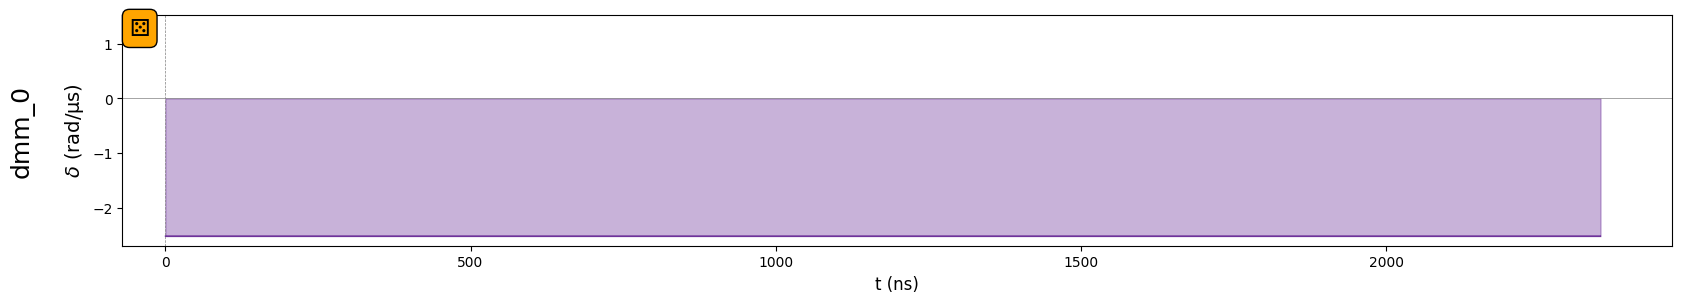

In [58]:
seq = Sequence(register, device_used)
seq.config_detuning_map(det_map_from_reg, "dmm_0")
print(seq.declared_channels)

total_duration = t_rise + t_sweep + t_fall
waveform = ConstantWaveform(total_duration, -delta_f/5)

# Concatenate the waveforms
seq.add_dmm_detuning(waveform, "dmm_0")
seq.draw(draw_detuning_maps=True)

We then create the **pulse sequence** for the rydberg chanel

In [59]:
# set pulse
rise = Pulse.ConstantDetuning(
    amplitude=RampWaveform(duration=t_rise, start=0.0, stop=omega_max), detuning=delta_0, phase=0.0,
)

sweep = Pulse.ConstantAmplitude(
    amplitude=omega_max, detuning=RampWaveform(duration=t_sweep, start=delta_0, stop=delta_f), phase=0.0,
)

fall = Pulse.ConstantDetuning(
    amplitude=RampWaveform(duration=t_fall, start=omega_max, stop=0.0), detuning=delta_f, phase=0.0,
)

In [60]:
seq.declare_channel("ryd_glob", "rydberg_global")

In [61]:
print(seq.declared_channels)
seq.add(rise, 'ryd_glob', "no-delay")
seq.add(sweep, 'ryd_glob', "no-delay")
seq.add(fall, 'ryd_glob', "no-delay")

{'dmm_0': DMM.Global(Max Absolute Detuning: None, Max Amplitude: 0, Clock period: 1 ns, Minimum pulse duration: 1 ns, Maximum pulse duration: 100000000 ns, Basis: 'ground-rydberg'), 'ryd_glob': Rydberg.Global(Max Absolute Detuning: None, Max Amplitude: None, Clock period: 1 ns, Minimum pulse duration: 1 ns, Basis: 'ground-rydberg')}


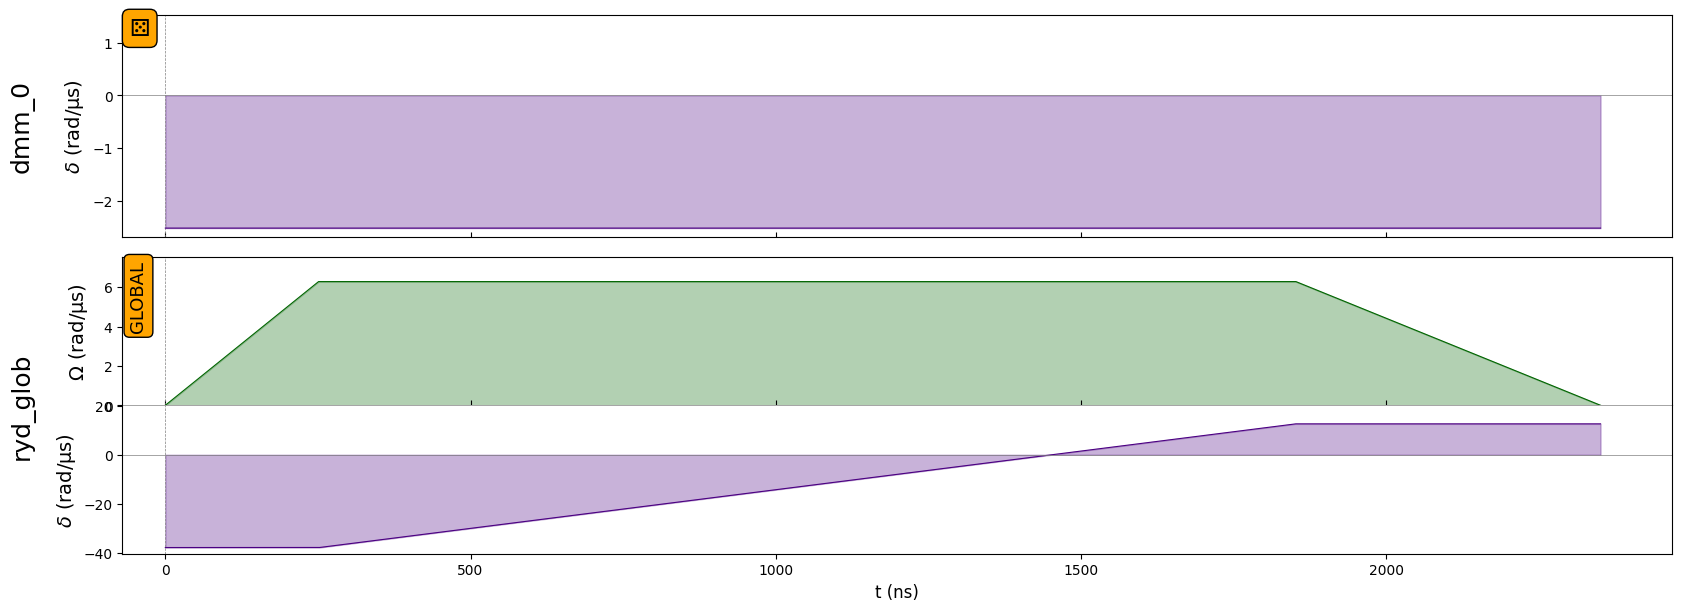

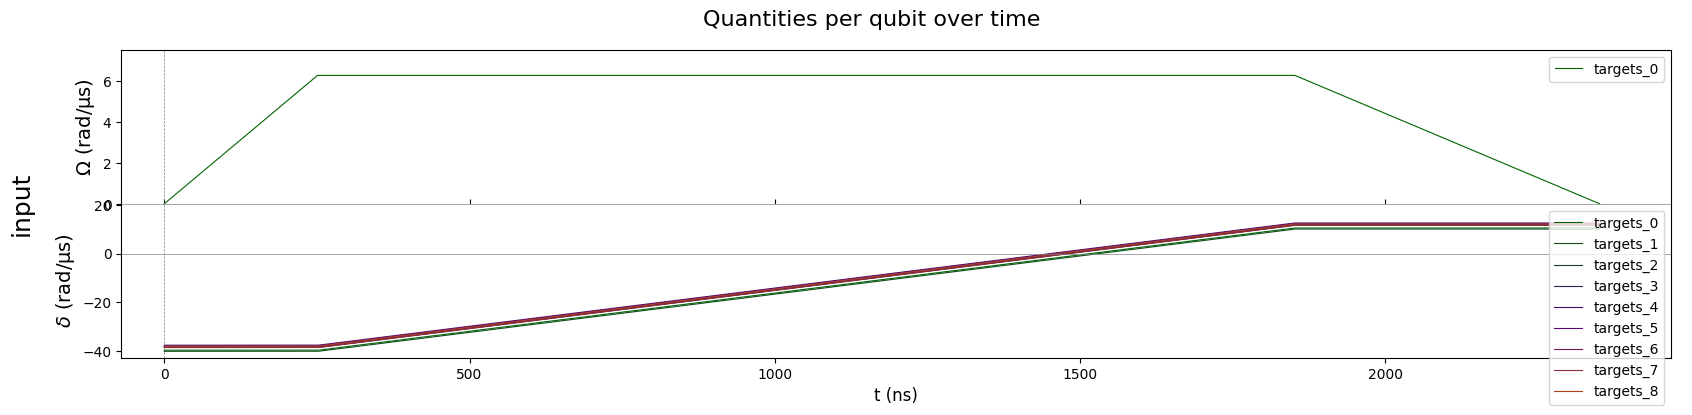

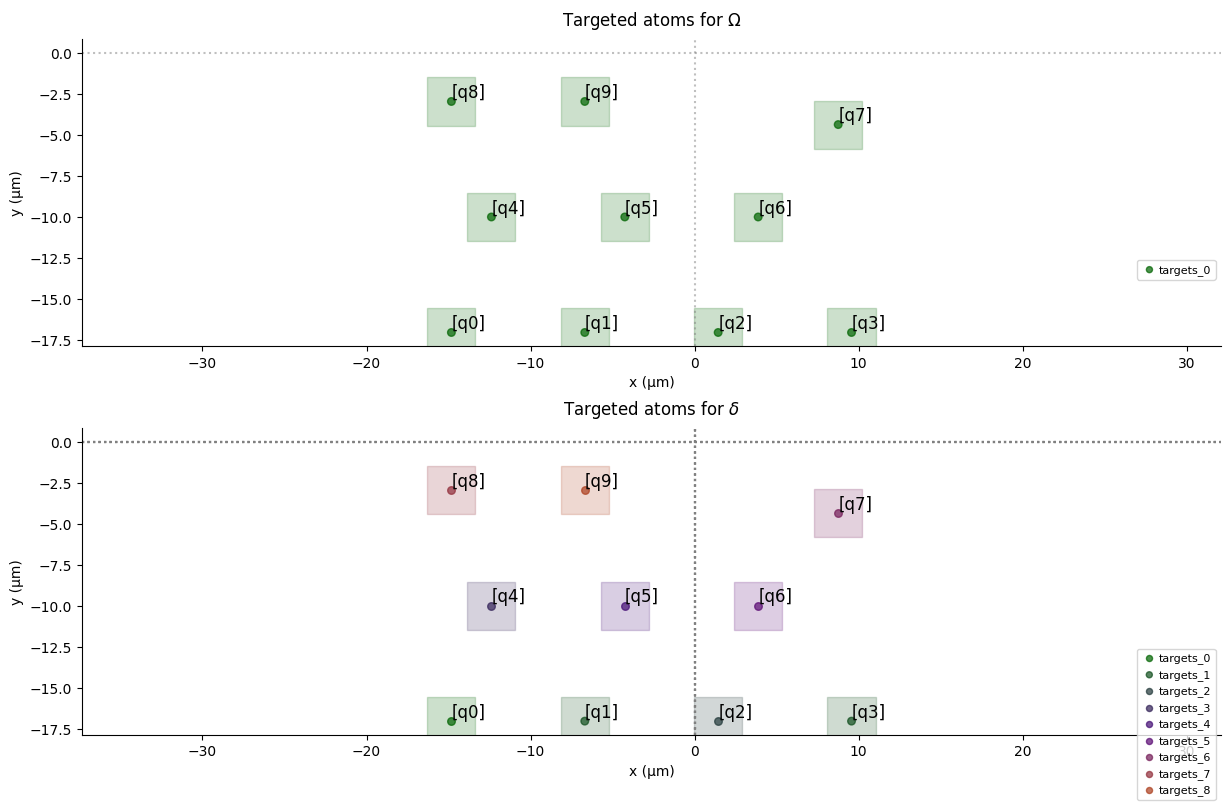

In [62]:
seq.draw(
    mode="input+output",  # "input" only shows input signals, "input+output"
    draw_qubit_det=True,
    draw_qubit_amp=True,
)

In [63]:
noise_config = {
    "noiseless": None,
    "noisy": SimConfig(
        noise = ("SPAM", "dephasing", "doppler"),
        eta = 0.8,
        temperature = 1000,
        runs = 50,
    )
}

In [64]:
simulator = QutipEmulator.from_sequence(
    seq, 
    sampling_rate=1,
    with_modulation = False,
    config=noise_config["noiseless"],
)

simulator.show_config()
results = simulator.run(progress_bar=True)
count_dict = results.sample_final_state(N_samples=10000)

Options:
----------
Number of runs:        15
Samples per run:       5
10.0%. Run time:   1.24s. Est. time left: 00:00:00:11
20.0%. Run time:   2.65s. Est. time left: 00:00:00:10
30.0%. Run time:   3.10s. Est. time left: 00:00:00:07
40.0%. Run time:   3.49s. Est. time left: 00:00:00:05
50.0%. Run time:   3.97s. Est. time left: 00:00:00:03
60.0%. Run time:   4.49s. Est. time left: 00:00:00:02
70.0%. Run time:   5.04s. Est. time left: 00:00:00:02
80.0%. Run time:   5.69s. Est. time left: 00:00:00:01
90.0%. Run time:   6.45s. Est. time left: 00:00:00:00
Total run time:   7.05s


In [65]:
most_frequent = {k:v for k,v in count_dict.items() if v>20}
C = dict(sorted(most_frequent.items(), key=lambda item: item[1], reverse=True))

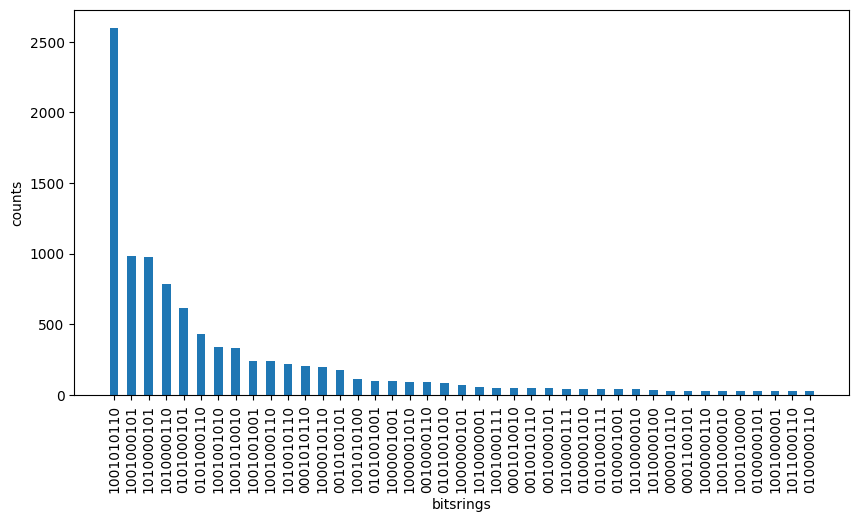

In [66]:
plt.figure(figsize=(10, 5))
plt.xlabel('bitsrings')
plt.ylabel('counts')
plt.bar(C.keys(), C.values(), width=0.5)
plt.xticks(rotation="vertical")
plt.show()

Most weighted independent set: 1001010110 with counts 2599
Most counts independent set: 1001010110 with counts 2599


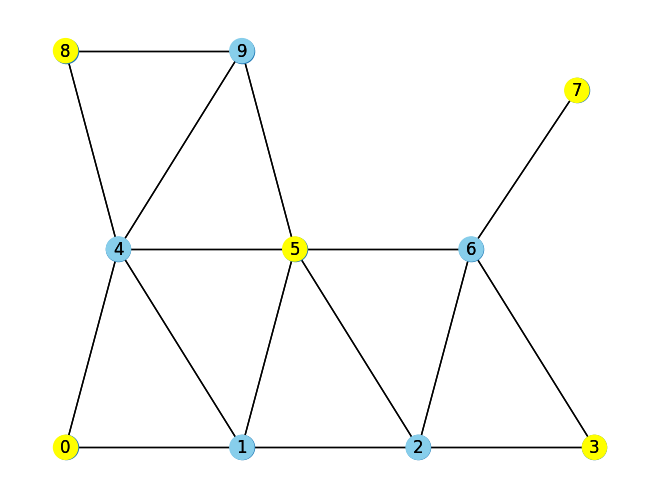

In [68]:
# Sort the bitstrings in descending order by frequency
solution = [key for key, value in sorted(most_frequent.items(), key=lambda item: item[1], reverse=True)]

# Function to convert a bitstring to a list of node indices included in the set
def convert_to_indices(bitstring):
    return [i for i, bit in enumerate(bitstring) if bit == '1']

# Function to check if a set of nodes is an independent set
def is_independent_set(graph, node_indices):
    for node in node_indices:
        for neighbor in graph.neighbors(node):
            if neighbor in node_indices:
                return False
    return True

# Find the maximum weight for valid independent sets
list_weights = []
valid_solutions = []
for sol in solution:
    highlighted = convert_to_indices(sol)
    # Check if highlighted nodes form an independent set
    if is_independent_set(graph, highlighted):
        valid_solutions.append(sol)
        list_weights.append(np.sum(highlighted))


# If there are valid independent sets, find the one with the maximum weight
if valid_solutions:
    ind_max = np.argmax(list_weights)
    highlighted_nodes = convert_to_indices(valid_solutions[ind_max])
    print(f'Most weighted independent set: {valid_solutions[ind_max]} with counts {C[str(valid_solutions[ind_max])]}')
    print(f'Most counts independent set: {solution[0]} with counts {C[str(solution[0])]}')
else:
    highlighted_nodes = []  # No valid independent set found

# Draw the graph with colored nodes
nx.draw(graph, pos=coords)
nx.draw_networkx_labels(graph, pos=coords)

# Assign colors: 'yellow' for highlighted nodes, 'skyblue' for others
node_colors = ['yellow' if node in highlighted_nodes else 'skyblue' for node in graph.nodes()]

nx.draw(graph, pos=coords, node_color=node_colors, with_labels=True)
